In [1]:
!pip install ensemble_boxes

In [34]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from ensemble_boxes import *
import pandas as pd
import numpy as np
from pycocotools.coco import COCO

In [35]:
submission_files = [
    './ensemble_files/swin_dyhead_6812.csv', 
    './ensemble_files/swin_faster_6253.csv', 
    './ensemble_files/yolox_l_5600.csv',
    # './ensemble_files/resnext101_autoassign_5058.csv',
    # './ensemble_files/res101_detectors_5014.csv',
]

submission_df = [pd.read_csv(file) for file in submission_files]
# submission_df

# [4871 rows x 2 columns],
#                                         PredictionString       image_id
#  0     0 0.7046413 475.82785 588.4447 560.9632 664.91...  test/0000.jpg
#  1     0 0.05763366 353.7803 237.6536 756.02454 703.8...  test/0001.jpg
#  2     0 0.9907233 873.9892 460.96442 1017.98016 628....  test/0002.jpg

In [36]:
image_ids = submission_df[0]['image_id'].tolist()
# image_ids

# 'test/0943.jpg',
# 'test/0944.jpg',
# 'test/0945.jpg',
# 'test/0946.jpg',
# 'test/0947.jpg',

In [37]:
annotation = '../../dataset/test.json'
coco = COCO(annotation)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [38]:
prediction_strings = []
file_names = []

iou_thr = 0.7 # hparam
submission_weights = [10, 6, 4] # hparam

for i, image_id in enumerate(tqdm(image_ids)):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    # print(image_info)
    # {'width': 1024, 'height': 1024, 'file_name': 'test/4814.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2020-12-26 16:08:36', 'id': 4814}
    w, h = image_info['width'], image_info['height']

    weights = []
    for j, df in enumerate(submission_df):
        predict_string = df[df['image_id']==image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()

        if len(predict_list)==0 or len(predict_list)==1:
            continue

        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []

        # for box in predict_list[:, 2:6].tolist():
        #     box[0] = float(box[0]) / image_info['width']
        #     box[1] = float(box[1]) / image_info['height']
        #     box[2] = float(box[2]) / image_info['width']
        #     box[3] = float(box[3]) / image_info['height']
        #     box_list.append(box)
        
        for box in predict_list[:, 2:6].tolist():
            box = (np.array(box).astype(np.float32) / np.array([w, h, w, h])).clip(0., 1.)
            # box[0] = float(box[0]) / image_info['width']
            # box[1] = float(box[1]) / image_info['height']
            # box[2] = float(box[2]) / image_info['width']
            # box[3] = float(box[3]) / image_info['height']
            # if box[0] == box[2] or box[1] == box[3]:
            #     print(j)
            #     break
            box = box.tolist()
            box_list.append(box)
        
        weights.append(submission_weights[j])

        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
    if len(boxes_list):
        # https://github.com/ZFTurbo/Weighted-Boxes-Fusion
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)                    


100%|██████████| 4871/4871 [01:19<00:00, 61.19it/s]


In [39]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('wbf_ensemble.csv', index=False)
submission

,PredictionString,image_id
0,7 0.915412187576294 604.9465942382812 519.8466...,test/0000.jpg
1,5 0.6259040594100952 129.42617797851562 1.1869...,test/0001.jpg
2,1 0.7284997701644897 297.7566833496094 321.025...,test/0002.jpg
3,9 0.547864294052124 159.28160095214844 263.367...,test/0003.jpg
4,0 0.45661450624465943 430.1637268066406 407.47...,test/0004.jpg
...,...,...
4866,0 0.364966893196106 295.20330810546875 348.095...,test/4866.jpg
4867,3 0.6401759862899781 413.9541931152344 325.382...,test/4867.jpg
4868,7 0.6517169237136841 113.56876373291016 469.24...,test/4868.jpg
4869,0 0.6468543291091919 3.794131278991699 220.524...,test/4869.jpg


1953


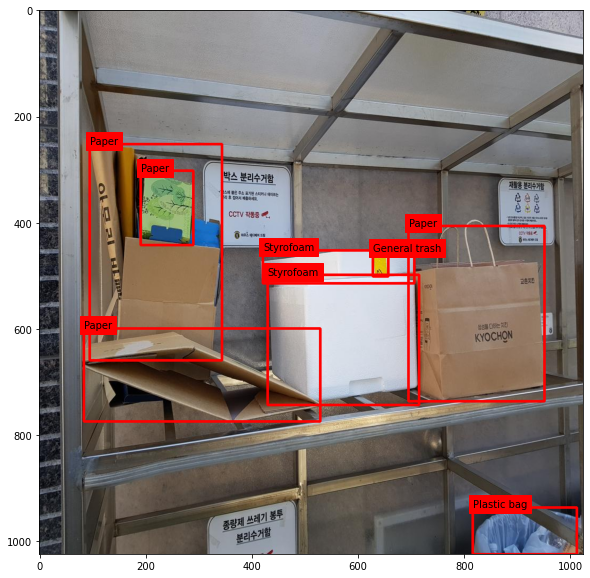

In [47]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

df = submission

data_root = '/opt/ml/detection/dataset/'

idx = np.random.randint(0, 4871)
print(idx)
score_thr = 0.5

img_path = os.path.join(data_root, df['image_id'][idx])
# print(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pred_str = df['PredictionString'][idx]
# print(pred_str)
pred_str_split = pred_str.split(' ')[:-1]
# print(pred_str_split)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in range(0, len(pred_str_split), 6):
    pred = pred_str_split[i:i+6]
    # print(pred)
    # ['1', '0.9313058257102966', '335.9405822753906', '215.4745330810547', '644.8052368164062', '403.897705078125']
    if pred:
        cls_idx = pred[0]
        score = float(pred[1])
        l, t, r, b = [round(float(x)) for x in pred[2:]]
        # print(cls_idx, score, l, t, r, b)
        # 1 0.9313058257102966 336 215 645 404
        if score >= score_thr:
            img = cv2.rectangle(img, (l, t), (r, b), (255, 0, 0), 3)
            ax.text(x=l, y=t, s=classes[int(cls_idx)], backgroundcolor='red')

plt.imshow(img)
plt.show()